In [1]:
import warnings
warnings.simplefilter('ignore')
import tensorflow as tf

In [2]:
print("Is GPU available?", tf.test.is_gpu_available())
print("TF version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available? True
TF version: 2.3.1
Keras version: 2.4.0


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE

from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import random
import gym

In [4]:
class RBuffer():
    def __init__(self, maxsize, statedim, naction):
        self.cnt = 0
        self.maxsize = maxsize
        self.state_memory = np.zeros((maxsize, *statedim), dtype=np.float32)
        self.action_memory = np.zeros((maxsize, naction), dtype=np.float32)
        self.reward_memory = np.zeros((maxsize,), dtype=np.float32)
        self.n_state_memory = np.zeros((maxsize, *statedim), dtype=np.float32)
        self.done_memory = np.zeros((maxsize,), dtype= np.bool)

    def store(self, state, action, reward, n_state, done):
        index = self.cnt % self.maxsize
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.n_state_memory[index] = n_state
        self.done_memory[index] = 1 - int(done)
        self.cnt += 1

    def take_data(self, batch_size):
        max_mem = min(self.cnt, self.maxsize)
        batch = np.random.choice(max_mem, batch_size, replace= False)  
        states = self.state_memory[batch]
        n_states = self.n_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        dones = self.done_memory[batch]
        return states, actions, rewards, n_states, dones

In [5]:
class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.f1 = tf.keras.layers.Dense(512, activation='relu')
        self.f2 = tf.keras.layers.Dense(512, activation='relu')
        self.v =  tf.keras.layers.Dense(1, activation=None)

    def call(self, inputstate, action):
        x = self.f1(tf.concat([inputstate, action], axis=1))
        x = self.f2(x)
        x = self.v(x)
        return x


class Actor(tf.keras.Model):
    def __init__(self, no_action):
        super(Actor, self).__init__()    
        self.f1 = tf.keras.layers.Dense(512, activation='relu')
        self.f2 = tf.keras.layers.Dense(512, activation='relu')
        self.mu =  tf.keras.layers.Dense(no_action, activation='tanh')

    def call(self, state):
        x = self.f1(state)
        x = self.f2(x)
        x = self.mu(x)  
        return x

In [6]:
class Agent():
    def __init__(self, n_actions, min_action, max_action):
        self.actor = Actor(n_actions)
        self.critic = Critic()
        self.actor_target = Actor(n_actions)
        self.critic_target = Critic()
        self.batch_size = 64
        self.n_actions = n_actions
        self.actor_opt = Adam(1e-4)
        self.critic_opt = Adam(1e-4)
        #self.memory = deque(maxlen=100000)
        self.memory = RBuffer(100000, (8, ), 2)
        self.steps = 0
        self.replace = 5
        self.gamma = 0.99
        self.min_action = min_action
        self.max_action = max_action
        self.tau = 0.005
        self.actor_target.compile(optimizer=self.actor_opt)
        self.critic_target.compile(optimizer=self.critic_opt)
    
    def store(self, state, action, reward, n_state, done):
        pack = [np.expand_dims(state, axis=0), action, reward, np.expand_dims(n_state, axis=0), done]
        self.memory.append(pack)
    
    def take_data(self, batch_size):
        pack = random.sample(self.memory, batch_size)
        states = []
        actions = []
        rewards = []
        n_states = []
        dones = []
        for i in range(batch_size):
            states.append(pack[i][0])
            actions.append(pack[i][1])
            rewards.append(pack[i][2])
            n_states.append(pack[i][3])
            dones.append(pack[i][4])
        return states, actions, rewards, n_states, dones


    def act(self, state, evaluate=False):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        actions = self.actor(state)
        if not evaluate:
            actions += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=0.1)

        actions = self.max_action * (tf.clip_by_value(actions, self.min_action, self.max_action))
        return actions[0]
    
    def update_target(self, tau=None):
        if tau is None:
            tau = self.tau

        weights1 = []
        targets1 = self.actor_target.weights
        for i, weight in enumerate(self.actor.weights):
            weights1.append(weight * tau + targets1[i]*(1-tau))
        self.actor_target.set_weights(weights1)

        weights2 = []
        targets2 = self.critic_target.weights
        for i, weight in enumerate(self.critic.weights):
            weights2.append(weight * tau + targets2[i]*(1-tau))
        self.critic_target.set_weights(weights2)
    
    def upgrade(self):
        if self.memory.cnt < 3*self.batch_size:
            return 

        states, actions, rewards, n_states, dones = self.memory.take_data(self.batch_size)

        states = tf.convert_to_tensor(states, dtype= tf.float32)
        n_states = tf.convert_to_tensor(n_states, dtype= tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype= tf.float32)
        actions = tf.convert_to_tensor(actions, dtype= tf.float32)

        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:

            target_actions = self.actor_target(n_states)
            target_n_state = tf.squeeze(self.critic_target(n_states, target_actions), 1)
            critic_value = tf.squeeze(self.critic(states, actions), 1)
            target_values = rewards + self.gamma * target_n_state * dones
            critic_loss = tf.keras.losses.MSE(target_values, critic_value)

            new_policy_actions = self.actor(states)
            actor_loss = -self.critic(states, new_policy_actions)
            actor_loss = tf.math.reduce_mean(actor_loss)

        grads1 = tape1.gradient(actor_loss, self.actor.trainable_variables)
        grads2 = tape2.gradient(critic_loss, self.critic.trainable_variables)
        self.actor_opt.apply_gradients(zip(grads1, self.actor.trainable_variables))
        self.critic_opt.apply_gradients(zip(grads2, self.critic.trainable_variables))
        
        self.update_target()

        self.steps +=1

In [7]:
env = gym.make('LunarLanderContinuous-v2')

print('Min_action:', env.action_space.low[0])
print('Max_action: ', env.action_space.high[0])
print('States: ', env.observation_space.shape)
print('Actions: ', env.action_space.shape)

Min_action: -1.0
Max_action:  1.0
States:  (8,)
Actions:  (2,)


In [8]:
agent = Agent(2, -1, 1)

n_episodes = 2000
avg_hist = []
scores = []

for i in range(n_episodes):
    score = 0 
    state = env.reset()
    done = False

    while not done:
        action = agent.act(state)
        n_state, reward, done, _ = env.step(action)
        agent.memory.store(state, action, reward, n_state, done)
        agent.upgrade()
        state = n_state
        score += reward
    
    scores.append(score)
    avg_reward = int(np.mean(scores[-100:]))
    avg_hist.append(avg_reward)
    print(f'Episode: {i}  Score: {score}  AVG: {avg_reward}')
    
    if avg_reward >= 200:
        break

env.close()

Episode: 0  Score: -138.63760360875517  AVG: -138
Episode: 1  Score: -288.17082639209445  AVG: -213
Episode: 2  Score: -228.09432249356544  AVG: -218
Episode: 3  Score: -375.364514604419  AVG: -257
Episode: 4  Score: -58.42399640938502  AVG: -217
Episode: 5  Score: -141.1209525514501  AVG: -204
Episode: 6  Score: -105.20447153843132  AVG: -190
Episode: 7  Score: -2.8650249938707617  AVG: -167
Episode: 8  Score: -108.02753389543975  AVG: -160
Episode: 9  Score: -158.59097306323645  AVG: -160
Episode: 10  Score: -155.3312360838984  AVG: -159
Episode: 11  Score: -80.82933503831245  AVG: -153
Episode: 12  Score: -385.90357210461724  AVG: -171
Episode: 13  Score: -68.73067687453185  AVG: -163
Episode: 14  Score: -157.9831665500176  AVG: -163
Episode: 15  Score: -83.67759341353931  AVG: -158
Episode: 16  Score: -141.91993261485385  AVG: -157
Episode: 17  Score: -38.897231486078134  AVG: -150
Episode: 18  Score: -131.84624462699387  AVG: -149
Episode: 19  Score: -122.75608943606636  AVG: -148

Episode: 162  Score: -112.87316116661988  AVG: -133
Episode: 163  Score: -299.35387341284945  AVG: -136
Episode: 164  Score: -228.6825297549192  AVG: -135
Episode: 165  Score: -329.0485131573962  AVG: -136
Episode: 166  Score: -136.85552041417094  AVG: -136
Episode: 167  Score: -60.65636095892091  AVG: -136
Episode: 168  Score: -280.76564855816895  AVG: -137
Episode: 169  Score: -207.2939736979362  AVG: -137
Episode: 170  Score: -183.83913707722235  AVG: -137
Episode: 171  Score: -269.0507839479559  AVG: -139
Episode: 172  Score: -358.24307169536047  AVG: -139
Episode: 173  Score: -375.5765484425669  AVG: -142
Episode: 174  Score: -173.76507184751978  AVG: -145
Episode: 175  Score: -115.35800501612049  AVG: -146
Episode: 176  Score: -161.85592171073202  AVG: -145
Episode: 177  Score: -352.48952151544745  AVG: -147
Episode: 178  Score: -298.21266008367525  AVG: -149
Episode: 179  Score: -197.60221001678286  AVG: -150
Episode: 180  Score: -227.08736081593094  AVG: -152
Episode: 181  Scor

Episode: 321  Score: -151.80360949761985  AVG: -163
Episode: 322  Score: -150.2865080960099  AVG: -162
Episode: 323  Score: -84.04697700422776  AVG: -162
Episode: 324  Score: -179.58305596298365  AVG: -162
Episode: 325  Score: -183.85452025460702  AVG: -162
Episode: 326  Score: -111.72039350957961  AVG: -159
Episode: 327  Score: -118.9461998310789  AVG: -158
Episode: 328  Score: -60.22624428556403  AVG: -157
Episode: 329  Score: -51.53405967832697  AVG: -156
Episode: 330  Score: -45.07257158377077  AVG: -155
Episode: 331  Score: -64.75546839125715  AVG: -152
Episode: 332  Score: -59.22483844153717  AVG: -150
Episode: 333  Score: -127.14879406238464  AVG: -151
Episode: 334  Score: -160.32117034182528  AVG: -151
Episode: 335  Score: -78.22393601268666  AVG: -150
Episode: 336  Score: -53.09068956774438  AVG: -149
Episode: 337  Score: -4.965158175829924  AVG: -146
Episode: 338  Score: -247.99131938571136  AVG: -148
Episode: 339  Score: -171.63762454181105  AVG: -148
Episode: 340  Score: -2

Episode: 484  Score: 200.17767037569047  AVG: -14
Episode: 485  Score: -16.05867666769058  AVG: -16
Episode: 486  Score: -104.67191379613725  AVG: -15
Episode: 487  Score: 89.53287839458324  AVG: -14
Episode: 488  Score: 168.9017188959199  AVG: -11
Episode: 489  Score: -57.49157695530539  AVG: -13
Episode: 490  Score: -61.219909397992396  AVG: -16
Episode: 491  Score: 97.53999773016228  AVG: -14
Episode: 492  Score: 221.5606432932854  AVG: -11
Episode: 493  Score: -1.5283395599658576  AVG: -11
Episode: 494  Score: -29.025570764034057  AVG: -13
Episode: 495  Score: 163.83827389287512  AVG: -11
Episode: 496  Score: -23.931040930356748  AVG: -10
Episode: 497  Score: 128.2914869425107  AVG: -9
Episode: 498  Score: -64.23276246307891  AVG: -9
Episode: 499  Score: -24.80311358636311  AVG: -9
Episode: 500  Score: -53.019474001644646  AVG: -9
Episode: 501  Score: -44.53541870072663  AVG: -8
Episode: 502  Score: 191.81972699829765  AVG: -5
Episode: 503  Score: -19.925873455399977  AVG: -5
Episo

Episode: 651  Score: 270.9938221862384  AVG: 130
Episode: 652  Score: 248.43544347012542  AVG: 130
Episode: 653  Score: 267.27373066108305  AVG: 131
Episode: 654  Score: 268.471702802599  AVG: 133
Episode: 655  Score: -80.53563110904969  AVG: 130
Episode: 656  Score: 276.64052288106114  AVG: 133
Episode: 657  Score: 236.7369843835706  AVG: 136
Episode: 658  Score: 73.52066467724683  AVG: 134
Episode: 659  Score: 204.3005932334146  AVG: 134
Episode: 660  Score: 244.8534851183701  AVG: 134
Episode: 661  Score: -354.74589634038756  AVG: 128
Episode: 662  Score: -10.494724850178287  AVG: 128
Episode: 663  Score: 213.4982027389729  AVG: 128
Episode: 664  Score: 279.11387806579376  AVG: 129
Episode: 665  Score: 249.47372513301195  AVG: 129
Episode: 666  Score: -20.60889551260368  AVG: 126
Episode: 667  Score: 266.3048850709969  AVG: 131
Episode: 668  Score: 277.2571259807815  AVG: 135
Episode: 669  Score: 269.54122275260636  AVG: 137
Episode: 670  Score: -23.92196443285726  AVG: 138
Episode:

Text(0, 0.5, 'Avg rewards')

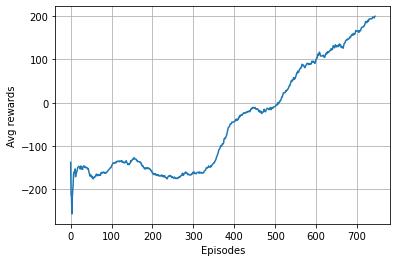

In [9]:
plt.plot(avg_hist)
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Avg rewards')

In [10]:
env = gym.make('LunarLanderContinuous-v2')

for i in range(10):
    state = env.reset()
    done = False
    
    while not done:
        action = agent.act(state, True)
        n_state, _, done, _ = env.step(action)
        state = n_state
        env.render()
env.close()

In [11]:
agent.actor.save_weights('actor_weights.h5')